In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

This example is taken and adapted from the torch example repository

In [3]:
BATCH_SIZE = 128

In [5]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True)

In [7]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [8]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [9]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [17]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [18]:
def test(epoch):
    model.eval()
    test_loss = 0
    for i, (data, _) in enumerate(test_loader):
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).data[0]
        if i == 0:
            n = min(data.size(0), 8)
            comparison = torch.cat([data[:n],
                                  recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]])
            save_image(comparison.data,
                     'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [19]:
for epoch in range(1, 10 + 1):
    train(epoch)
    test(epoch)
    sample = Variable(torch.randn(64, 20))
    sample = model.decode(sample)
    save_image(sample.data.view(64, 1, 28, 28),
               'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 130.947617
Train Epoch: 1 [2560/60000 (4%)]	Loss: 126.545685
Train Epoch: 1 [5120/60000 (9%)]	Loss: 123.523026
Train Epoch: 1 [7680/60000 (13%)]	Loss: 128.016113
Train Epoch: 1 [10240/60000 (17%)]	Loss: 129.142212
Train Epoch: 1 [12800/60000 (21%)]	Loss: 124.724266
Train Epoch: 1 [15360/60000 (26%)]	Loss: 125.705635
Train Epoch: 1 [17920/60000 (30%)]	Loss: 121.349472
Train Epoch: 1 [20480/60000 (34%)]	Loss: 123.418205
Train Epoch: 1 [23040/60000 (38%)]	Loss: 125.095291
Train Epoch: 1 [25600/60000 (43%)]	Loss: 123.296555
Train Epoch: 1 [28160/60000 (47%)]	Loss: 127.556244
Train Epoch: 1 [30720/60000 (51%)]	Loss: 119.878548
Train Epoch: 1 [33280/60000 (55%)]	Loss: 116.423630
Train Epoch: 1 [35840/60000 (60%)]	Loss: 122.963539
Train Epoch: 1 [38400/60000 (64%)]	Loss: 120.465958
Train Epoch: 1 [40960/60000 (68%)]	Loss: 119.415527
Train Epoch: 1 [43520/60000 (72%)]	Loss: 118.011818
Train Epoch: 1 [46080/60000 (77%)]	Loss: 115.847961
Train Epoch: 1 [48640/

In [25]:
from IPython.display import Image

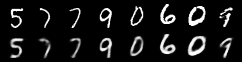

In [30]:
Image("results/reconstruction_3.png")

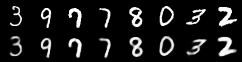

In [33]:
Image("results/reconstruction_9.png")